# Project Big Data Neferu

# Imports

In [1]:
! pip install pyspark

In [2]:
import numpy as np
from pyspark.sql import functions
from pyspark.sql.functions import col
import pyspark
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
import tensorflow as tf

In [3]:
from pyspark import SparkContext

try:
    sc = SparkContext('local', 'Pyspark demo')
except ValueError:
    print('SparkContext already exists!')

from pyspark.sql import SparkSession

try:
    spark = SparkSession.builder.appName('Recommendation_system').getOrCreate()
except ValueError:
    print('SparkSession already exists!')

# Data Preprocessing

In [4]:
df_ = spark.read.option('header', True).format('csv').load('/content/SolarPrediction.csv')

In [5]:
df_.show()

+----------+--------------------+--------+---------+-----------+--------+--------+----------------------+-----+-----------+----------+
|  UNIXTime|                Data|    Time|Radiation|Temperature|Pressure|Humidity|WindDirection(Degrees)|Speed|TimeSunRise|TimeSunSet|
+----------+--------------------+--------+---------+-----------+--------+--------+----------------------+-----+-----------+----------+
|1475229326|9/29/2016 12:00:0...|23:55:26|     1.21|         48|   30.46|      59|                177.39| 5.62|   06:13:00|  18:13:00|
|1475229023|9/29/2016 12:00:0...|23:50:23|     1.21|         48|   30.46|      58|                176.78| 3.37|   06:13:00|  18:13:00|
|1475228726|9/29/2016 12:00:0...|23:45:26|     1.23|         48|   30.46|      57|                158.75| 3.37|   06:13:00|  18:13:00|
|1475228421|9/29/2016 12:00:0...|23:40:21|     1.21|         48|   30.46|      60|                137.71| 3.37|   06:13:00|  18:13:00|
|1475228124|9/29/2016 12:00:0...|23:35:24|     1.17|   

In [6]:
columns = ['UNIXTime', 'Data', 'Time', 'Radiation', 'Temperature', 'Pressure', 'Humidity','WindDirection(Degrees)','Speed', 'TimeSunRise','TimeSunSet']
rows = df_.count()
cnt = 0

In [7]:
for index, column in enumerate(columns):

    notNull = df_.filter(col(str(column)).isNotNull()).count()

    if  notNull != rows:
        print('There are '+str(rows - notNull)+' Null values in the date column')
    else:
        cnt += 1

    if cnt != index+1:
        print('There are not NULL values in the '+str(column)+' column')

    elif cnt == len(columns):
        print('There are not NULL values in the data frame')

There are not NULL values in the data frame


In [8]:
# Data

split_col = pyspark.sql.functions.split(df_['Data'], '/')
df_ = df_.withColumn('Month', split_col.getItem(0))
df_ = df_.withColumn('Day', split_col.getItem(1))
df_ = df_.withColumn('YearAux', split_col.getItem(2)) # year + time

In [9]:
# Time

split_col = pyspark.sql.functions.split(df_['Time'], ':')
df_ = df_.withColumn('Hour', split_col.getItem(0))
df_ = df_.withColumn('Minute', split_col.getItem(1))
df_ = df_.withColumn('Second', split_col.getItem(2))

In [10]:
columns.append('Month')
columns.append('Day')
columns.append('Hour')
columns.append('Minute')
columns.append('Second')

In [11]:
df = df_.select([column for column in columns if column not in ['Time', 'Data', 'YearAux', 'TimeSunRise', 'TimeSunSet', 'UNIXTime']])

In [12]:
df.show()

+---------+-----------+--------+--------+----------------------+-----+-----+---+----+------+------+
|Radiation|Temperature|Pressure|Humidity|WindDirection(Degrees)|Speed|Month|Day|Hour|Minute|Second|
+---------+-----------+--------+--------+----------------------+-----+-----+---+----+------+------+
|     1.21|         48|   30.46|      59|                177.39| 5.62|    9| 29|  23|    55|    26|
|     1.21|         48|   30.46|      58|                176.78| 3.37|    9| 29|  23|    50|    23|
|     1.23|         48|   30.46|      57|                158.75| 3.37|    9| 29|  23|    45|    26|
|     1.21|         48|   30.46|      60|                137.71| 3.37|    9| 29|  23|    40|    21|
|     1.17|         48|   30.46|      62|                104.95| 5.62|    9| 29|  23|    35|    24|
|     1.21|         48|   30.46|      64|                 120.2| 5.62|    9| 29|  23|    30|    24|
|      1.2|         49|   30.46|      72|                112.45| 6.75|    9| 29|  23|    25|    19|


# Column type conversion

In [13]:
cols = ['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'Month', 'Day', 'Hour','Minute','Second']

In [14]:
#for column in cols:
#    df.withColumn( column, col(column).cast('float'))

In [15]:
def isfloat(x):
    try:
        float(x)
    except :
        return False
    else:
        return True
line1 = df.head(1)[0]

#df = df.select([c for c in df.columns if not isfloat(line1[c])] + [df[c].cast("float").alias(c) for c in df.columns if isfloat(line1[c])])
df = df.select([c for c in df.columns if not isfloat(line1[c])] + [df[c].cast("float").alias(c) for c in df.columns ])

# Train Test Splitting

In [16]:
train, test = df.randomSplit([0.7, 0.3], seed = 41)

# Creating freatures assembler

In [17]:
assembler = VectorAssembler(
    inputCols=['Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'Month', 'Day', 'Hour', 'Minute', 'Second'],
    outputCol='Features')


train_data = assembler.transform(train)
test_data = assembler.transform(test)

In [18]:
train_data =  train_data.select([column for column in ['Features', 'Radiation']])
test_data = test_data.select([column for column in ['Features', 'Radiation']])

# ML Models

## Linear Regression

In [19]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol = 'Radiation', featuresCol = 'Features')
lrModel = lr.fit(train_data)

prediction = lrModel.evaluate(test_data)

print("MAE: {}".format(prediction.meanAbsoluteError))

MAE: 146.64277488396166


## Random Forest

In [20]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(labelCol = 'Radiation',
                            featuresCol = 'Features')

In [21]:
featureIndexer =\
    VectorIndexer(inputCol="Features", outputCol="indexedFeatures", maxCategories=4).fit(train_data)

pipeline = Pipeline(stages=[featureIndexer, rf])

In [22]:
model = pipeline.fit(train_data)

In [49]:
predictions = model.transform(test_data)

evaluator = RegressionEvaluator(
    labelCol="Radiation", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
print("MAE on test data = %g" % mae)

rfModel = model.stages[1]
print(rfModel)

MAE on test data = 55.1361
GBTRegressionModel: uid=GBTRegressor_56079209ad03, numTrees=10, numFeatures=10


## Gradient-boosted tree regression

In [48]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

gbt = GBTRegressor(labelCol = 'Radiation', featuresCol="indexedFeatures", maxIter=10)

pipeline = Pipeline(stages=[featureIndexer, gbt])

model = pipeline.fit(train_data)

predictions = model.transform(test_data)

evaluator = RegressionEvaluator(
    labelCol="Radiation", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
print("MAE on test data = %g" % mae)

gbtModel = model.stages[1]
print(gbtModel)

MAE on test data = 55.1361
GBTRegressionModel: uid=GBTRegressor_56079209ad03, numTrees=10, numFeatures=10


# Deep learning model

In [25]:
cols = ['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'Month', 'Day', 'Hour','Minute','Second']

training_labels = train.select([column for column in cols if column in ['Radiation']])
testing_labels = test.select([column for column in cols if column in ['Radiation']])

training_data = train.select([column for column in cols if column not in ['Radiation']])
testing_data = test.select([column for column in cols if column not in ['Radiation']])

pd_train_data = training_data.toPandas()
pd_test_data  = testing_data.toPandas()

pd_train_labels = training_labels.toPandas()
pd_test_labels  = testing_labels.toPandas()


In [26]:
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam
from keras.models import Sequential


model = Sequential()
    
model.add(Dense(128, activation='relu', input_dim=10))
model.add(Dropout(0.33))
    
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(1, activation='linear'))
    
model.compile(metrics='mae', loss='mae', optimizer=Adam(learning_rate=0.0001))
history = model.fit(pd_train_data, pd_train_labels, validation_data=(pd_test_data, pd_test_labels), epochs=50, batch_size=32)

Epoch 1/50
712/712 [==============================] - 17s 3ms/step - loss: 209.6210 - mae: 209.6210 - val_loss: 186.2994 - val_mae: 186.2994
Epoch 2/50
712/712 [==============================] - 2s 2ms/step - loss: 189.1419 - mae: 189.1419 - val_loss: 166.0867 - val_mae: 166.0867
Epoch 3/50
712/712 [==============================] - 2s 2ms/step - loss: 167.1989 - mae: 167.1989 - val_loss: 151.2995 - val_mae: 151.2995
Epoch 4/50
712/712 [==============================] - 2s 2ms/step - loss: 157.5288 - mae: 157.5288 - val_loss: 142.2683 - val_mae: 142.2683
Epoch 5/50
712/712 [==============================] - 2s 2ms/step - loss: 147.8938 - mae: 147.8938 - val_loss: 136.5696 - val_mae: 136.5696
Epoch 6/50
712/712 [==============================] - 2s 2ms/step - loss: 145.9737 - mae: 145.9737 - val_loss: 132.3449 - val_mae: 132.3449
Epoch 7/50
712/712 [==============================] - 2s 2ms/step - loss: 142.5272 - mae: 142.5272 - val_loss: 128.7739 - val_mae: 128.7739
Epoch 8/50
712/712 

In [27]:
model.evaluate(pd_test_data, pd_test_labels)

311/311 [==============================] - 0s 988us/step - loss: 72.8963 - mae: 72.8963


[72.8963394165039, 72.8963394165039]

## Another arhitecture

In [28]:
from keras.layers import Dense, Dropout
from keras import regularizers

model = Sequential()
model.add(Dense(64, activation='relu',  kernel_initializer='normal', input_dim=10, kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

In [29]:
model.compile(metrics='mae', loss='mae', optimizer=Adam(learning_rate=0.0001))
history = model.fit(pd_train_data, pd_train_labels, validation_data=(pd_test_data, pd_test_labels), epochs=300, batch_size=32)

Epoch 1/300
712/712 [==============================] - 5s 5ms/step - loss: 195.0887 - mae: 190.3857 - val_loss: 139.2963 - val_mae: 135.2273
Epoch 2/300
712/712 [==============================] - 3s 4ms/step - loss: 141.0431 - mae: 137.0658 - val_loss: 128.8280 - val_mae: 125.0278
Epoch 3/300
712/712 [==============================] - 3s 4ms/step - loss: 128.1371 - mae: 124.3690 - val_loss: 112.6265 - val_mae: 108.9340
Epoch 4/300
712/712 [==============================] - 3s 4ms/step - loss: 124.9578 - mae: 121.2914 - val_loss: 110.1214 - val_mae: 106.5276
Epoch 5/300
712/712 [==============================] - 2s 3ms/step - loss: 120.4097 - mae: 116.8358 - val_loss: 108.6378 - val_mae: 105.1200
Epoch 6/300
712/712 [==============================] - 2s 3ms/step - loss: 118.6930 - mae: 115.1940 - val_loss: 106.2312 - val_mae: 102.7873
Epoch 7/300
712/712 [==============================] - 3s 4ms/step - loss: 114.3719 - mae: 110.9420 - val_loss: 106.6499 - val_mae: 103.2611
Epoch 8/300
7

In [29]:
model.evaluate(pd_test_data, pd_test_labels)

#Data Visualization

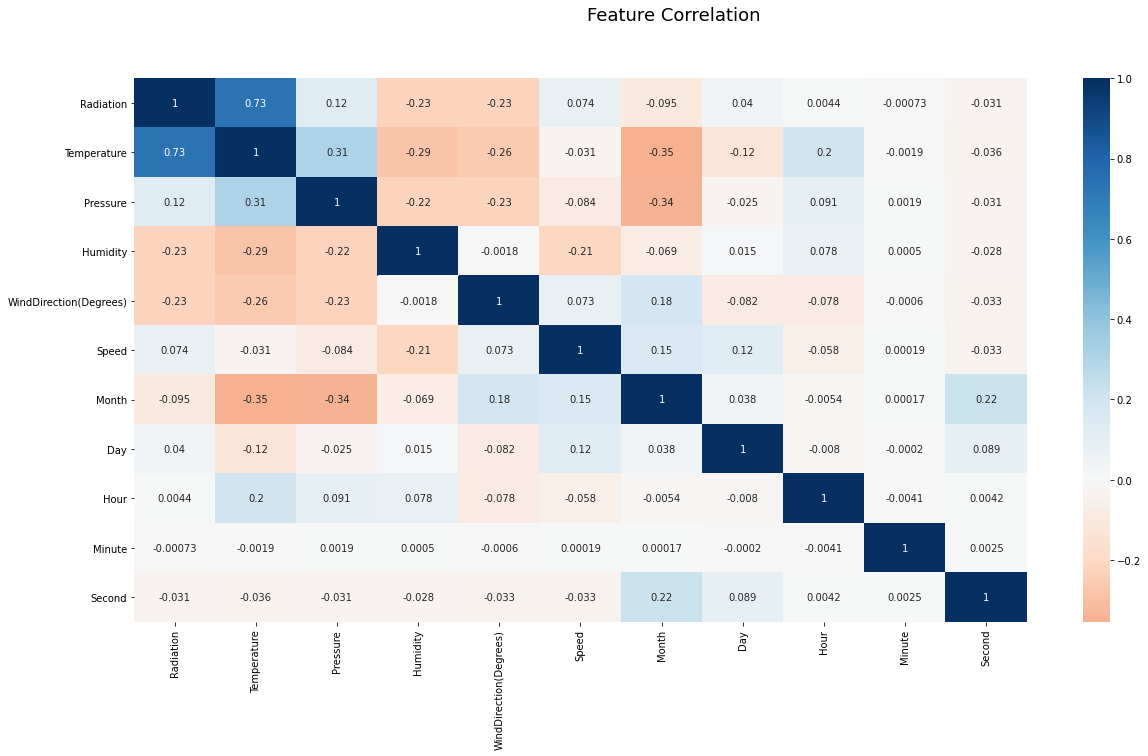

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

mydata = df.toPandas()
fig = plt.figure(figsize=(20,10))
fig.suptitle('Feature Correlation', fontsize=18)
sns.heatmap(mydata.corr(), annot=True, cmap='RdBu', center=0)

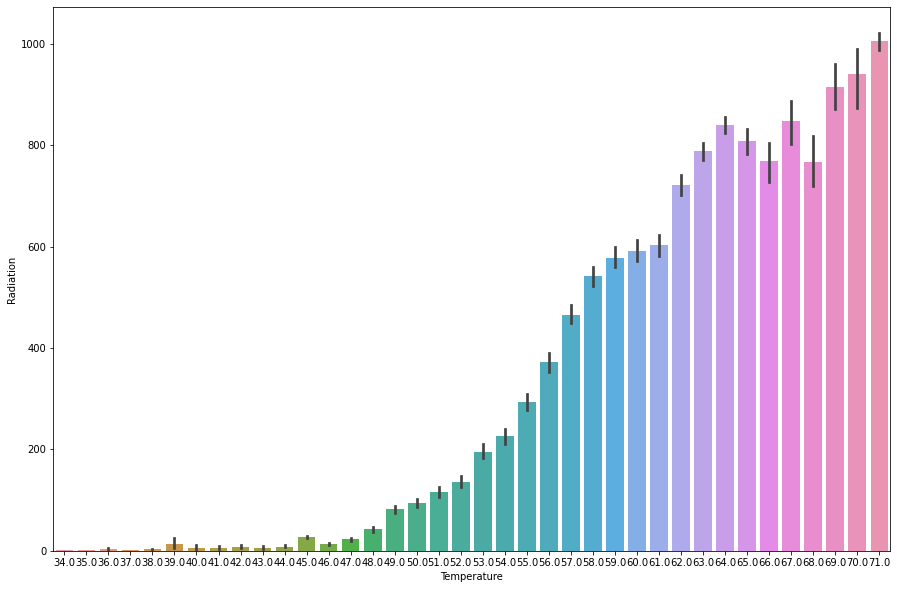

In [45]:
fig2 = plt.figure(figsize=(15,10))
sns.barplot(x=mydata['Temperature'],y=mydata['Radiation'])

#Temperatura este direct proporțională cu radiația, deci este o caracteristică importantă

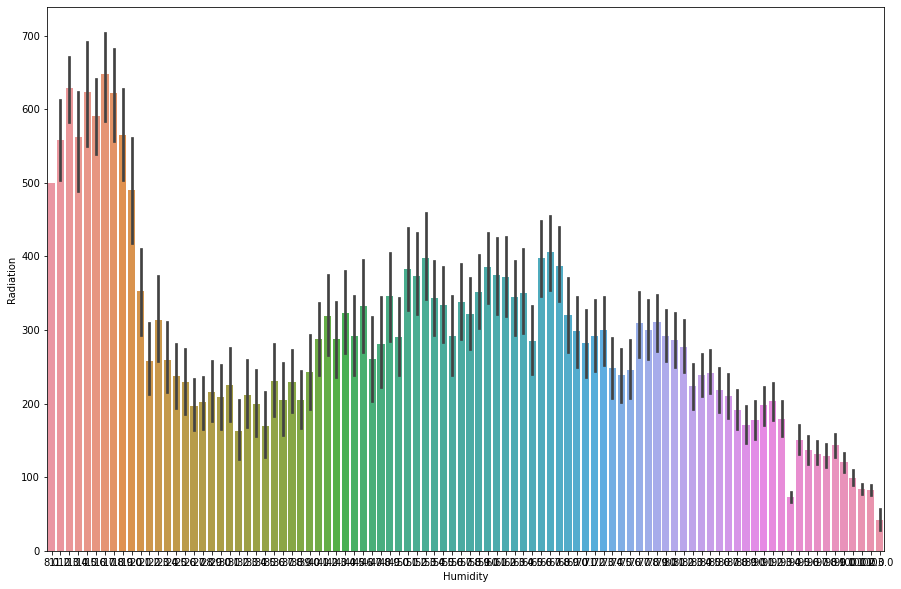

In [46]:
fig3 = plt.figure(figsize=(15,10))
sns.barplot(x=mydata['Humidity'],y=mydata['Radiation'])

# Pe măsură ce nivelul de umiditate scade, radiațiile tind să crească, astfel aceste două atribute par a fi invers proporționale.

# Outliers removal
Applying Z score for every feature and keeping the one that its absolute value is smaller than our threshhold(3)

In [33]:
# Temperature	Pressure	Humidity	WindDirection(Degrees)	Speed	Month	Day	Hour	Minute	Second
threshold = 4

outliers = [] 

for i in mydata['Temperature']: 
    z = (i- np.mean(mydata['Temperature']))/np.std(mydata['Temperature'])
    if z > threshold or z < 0-threshold: 
        outliers.append(i) 
print('The outliers in Temperature are: ', outliers) 

The outliers in Temperature are:  []


In [34]:
outliers = [] 

for i in mydata['Pressure']: 
    z = (i- np.mean(mydata['Pressure']))/np.std(mydata['Pressure'])
    if z > threshold or z < 0-threshold: 
        outliers.append(i) 
print('The outliers in Pressure are: ', outliers)

The outliers in Pressure are:  [30.200000762939453, 30.200000762939453, 30.200000762939453, 30.200000762939453, 30.200000762939453, 30.190000534057617, 30.200000762939453, 30.200000762939453, 30.190000534057617, 30.200000762939453, 30.200000762939453, 30.200000762939453, 30.200000762939453, 30.200000762939453, 30.190000534057617, 30.190000534057617, 30.190000534057617, 30.200000762939453, 30.190000534057617, 30.190000534057617, 30.190000534057617, 30.190000534057617, 30.190000534057617, 30.190000534057617, 30.190000534057617, 30.190000534057617, 30.190000534057617, 30.190000534057617, 30.190000534057617, 30.200000762939453, 30.190000534057617, 30.200000762939453, 30.200000762939453, 30.200000762939453, 30.200000762939453, 30.200000762939453, 30.200000762939453, 30.200000762939453, 30.200000762939453, 30.200000762939453, 30.200000762939453, 30.200000762939453, 30.200000762939453, 30.200000762939453, 30.200000762939453, 30.200000762939453, 30.200000762939453, 30.200000762939453, 30.20000

In [35]:
outliers = [] 

for i in mydata['Humidity']: 
    z = (i- np.mean(mydata['Humidity']))/np.std(mydata['Humidity'])
    if z > threshold or z < 0-threshold: 
        outliers.append(i) 
print('The outliers in Humidity are: ', outliers)

The outliers in Humidity are:  []


In [36]:
outliers = [] 

for i in mydata['WindDirection(Degrees)']: 
    z = (i- np.mean(mydata['WindDirection(Degrees)']))/np.std(mydata['WindDirection(Degrees)'])
    if z > threshold or z < 0-threshold: 
        outliers.append(i) 
print('The outliers in WindDirection(Degrees): ', outliers)

The outliers in WindDirection(Degrees):  []


In [37]:
outliers = [] 

for i in mydata['Speed']: 
    z = (i- np.mean(mydata['Speed']))/np.std(mydata['Speed'])
    if z > threshold or z < 0-threshold: 
        outliers.append(i) 
print('The outliers in Speed: ', outliers)

The outliers in Speed:  [20.25, 20.25, 20.25, 21.3700008392334, 23.6200008392334, 22.5, 22.5, 27.0, 20.25, 21.3700008392334, 23.6200008392334, 20.25, 29.25, 24.75, 23.6200008392334, 23.6200008392334, 24.75, 31.5, 23.6200008392334, 24.75, 20.25, 24.75, 23.6200008392334, 20.25, 20.25, 29.25, 23.6200008392334, 25.8700008392334, 33.75, 28.1200008392334, 36.0, 27.0, 24.75, 24.75, 31.5, 27.0, 32.619998931884766, 31.5, 30.3700008392334, 36.0, 22.5, 27.0, 25.8700008392334, 27.0, 33.75, 29.25, 21.3700008392334, 23.6200008392334, 20.25, 23.6200008392334, 33.75, 28.1200008392334, 36.0, 23.6200008392334, 25.8700008392334, 25.8700008392334, 32.619998931884766, 37.119998931884766, 25.8700008392334, 27.0, 21.3700008392334, 27.0, 24.75, 24.75, 28.1200008392334, 31.5, 23.6200008392334, 22.5, 24.75, 29.25, 28.1200008392334, 24.75, 30.3700008392334, 20.25, 25.8700008392334, 22.5, 21.3700008392334, 20.25, 30.3700008392334, 24.75, 31.5, 20.25, 30.3700008392334, 29.25, 31.5, 29.25, 34.869998931884766, 31.5,

In [38]:
outliers = [] 

for i in mydata['Month']: 
    z = (i- np.mean(mydata['Month']))/np.std(mydata['Month'])
    if z > threshold or z < 0-threshold: 
        outliers.append(i) 
print('The outliers in Month: ', outliers)

The outliers in Month:  []


In [39]:
threshold = 4
outliers = [] 

for i in mydata['Day']: 
    z = (i- np.mean(mydata['Day']))/np.std(mydata['Day'])
    if z > threshold or z < 0-threshold: 
        outliers.append(i) 
print('The outliers in Day: ', outliers)

The outliers in Day:  []


In [40]:
outliers = [] 

for i in mydata['Hour']: 
    z = (i- np.mean(mydata['Hour']))/np.std(mydata['Hour'])
    if z > threshold or z < 0-threshold: 
        outliers.append(i) 
print('The outliers in Hour: ', outliers)

The outliers in Hour:  []


In [41]:
outliers = [] 

for i in mydata['Minute']: 
    z = (i- np.mean(mydata['Minute']))/np.std(mydata['Minute'])
    if z > threshold or z < 0-threshold: 
        outliers.append(i) 
print('The outliers in Minute: ', outliers)

The outliers in Minute:  []


In [42]:
outliers = [] 

for i in mydata['Second']: 
    z = (i- np.mean(mydata['Second']))/np.std(mydata['Second'])
    if z > threshold or z < 0-threshold: 
        outliers.append(i) 
print('The outliers in Second: ', outliers)

The outliers in Second:  []


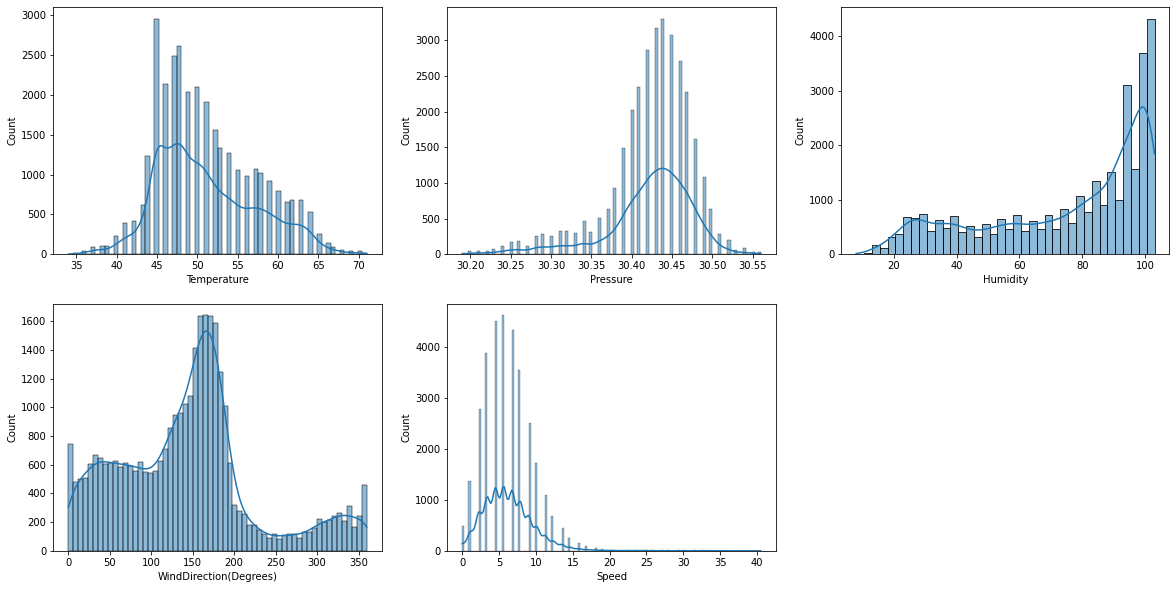

In [43]:
plt.figure(figsize=(20,10))

distr = mydata[["Temperature","Pressure","Humidity","WindDirection(Degrees)","Speed"]]

for i, column in enumerate(distr):
    plt.subplot(2,3,i+1)
    sns.histplot(distr[column],kde=True)